In [43]:
# Primero cargo los datos
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns 

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn import utils

In [2]:
# Read the data
X_train_full = pd.read_csv('./data/train.csv', index_col='Id')
X_test_full = pd.read_csv('./data/test.csv', index_col='Id')

In [3]:
# Veo de que va 
X_train_full.shape

(160435, 13)

In [4]:
X_train_full.head()

,Marca,Modelo,Tiempo,Provincia,Localidad,Año,Kms,Cambio,Cv,Combust,Puertas,Vendedor,Precio
Id,,,,,,,,,,,,,
0,OPEL,VECTRA,33 días,la_rioja,Arnedo,2005.0,200000.0,manual,120.0,diesel,5.0,Profesional,2200
1,NISSAN,PRIMERA,43 horas,aragon,Teruel,2008.0,400000.0,manual,100.0,diesel,4.0,Particular,3500
2,RENAULT,CLIO BUSINESS DCI 75 ECO2,14 horas,sevilla,Camas,2014.0,53565.0,manual,75.0,diesel,5.0,Profesional,8200
3,MERCEDES-BENZ,CLASE CLS,1 hora,burgos,Burgos,2007.0,215000.0,automat,224.0,diesel,4.0,Particular,12500
4,RENAULT,CAPTUR LIFE ENERGY DCI 90 ECO2 EURO 6,45 días,caceres,Caceres,2016.0,119945.0,manual,90.0,diesel,5.0,Profesional,9900


In [5]:
X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160435 entries, 0 to 160434
Data columns (total 13 columns):
Marca        160435 non-null object
Modelo       160435 non-null object
Tiempo       160435 non-null object
Provincia    160435 non-null object
Localidad    145457 non-null object
Año          157104 non-null float64
Kms          150278 non-null float64
Cambio       160375 non-null object
Cv           145378 non-null float64
Combust      160413 non-null object
Puertas      160198 non-null float64
Vendedor     160409 non-null object
Precio       160435 non-null int64
dtypes: float64(4), int64(1), object(8)
memory usage: 12.2+ MB


In [6]:
X_train_full.describe()

,Año,Kms,Cv,Puertas,Precio
count,157104.000000,1.502780e+05,145378.000000,160198.000000,1.604350e+05
mean,2009.094262,1.503070e+05,141.379143,4.495468,1.098547e+04
std,7.497642,2.325317e+05,431.262674,0.880793,5.549184e+04
min,1908.000000,1.000000e+00,1.000000,2.000000,2.500000e+01
25%,2004.000000,7.400000e+04,102.000000,4.000000,2.950000e+03
50%,2009.000000,1.400000e+05,125.000000,5.000000,7.000000e+03
75%,2015.000000,2.020000e+05,150.000000,5.000000,1.449000e+04
max,2020.000000,1.677722e+07,65535.000000,5.000000,1.180000e+07


In [7]:
# Esto no funciona porque es muy gordo el dataset
#from pandas_profiling import ProfileReport
#profile = ProfileReport(X_train_full)
#profile.to_file(output_file="./data/profile-X_train_full.html")

In [8]:
# Remove rows with missing target, separate target from predictors
# Me voy a cargar la localidad que no hace más que molestar
X_train_full.drop(['Localidad'], axis=1, inplace =True)
X_test_full.drop(['Localidad'], axis=1, inplace =True)

In [27]:
# Veo columnas numéricas y categóricas. El precio no entra en numérico porque es int64
numerical_columns = [col for col in X_train_full.columns if X_train_full[col].dtype == 'float64']
categorical_columns = [col for col in X_train_full.columns if X_train_full[col].dtype == 'object']

In [28]:
print(numerical_columns)
print(categorical_columns)

['Año', 'Kms', 'Cv', 'Puertas']
['Marca', 'Modelo', 'Tiempo', 'Provincia', 'Cambio', 'Combust', 'Vendedor']


In [29]:
# veo el número de columnas numéricas con nulos y cuantos tienen
for column in numerical_columns:
    numero_ceros = X_train_full[column].isnull().sum()
    if numero_ceros > 0:
        print("Columna ", column, "tiene ", numero_ceros, "ceros")

Columna  Año tiene  3315 ceros
Columna  Kms tiene  10133 ceros
Columna  Cv tiene  14998 ceros
Columna  Puertas tiene  178 ceros


In [30]:
# veo el número de columnas categóricas con nulos y cuantos tienen
for column in categorical_columns:
    numero_ceros = X_train_full[column].isnull().sum()
    if numero_ceros > 0:
        print("Columna ", column, "tiene ", numero_ceros, "ceros")

In [31]:
# Las columnas con 0 son poquísimas en las categóricas. Me las voy a cargar
X_train_full.dropna(subset=['Cambio', 'Combust', 'Vendedor'], inplace = True)

In [35]:
# Veo las columnas categóricas en los test y me las cargo
categorial_columns_test = [col for col in X_train_full.columns if X_train_full[col].dtype == 'object']

In [36]:
print(categorial_columns_test)

['Marca', 'Modelo', 'Tiempo', 'Provincia', 'Cambio', 'Combust', 'Vendedor']


In [37]:
# veo el número de ceros en los test
for column in categorial_columns_test:
    numero_ceros = X_test_full[column].isnull().sum()
    if numero_ceros > 0:
        print("Columna ", column, "tiene ", numero_ceros, "ceros")

Columna  Cambio tiene  24 ceros
Columna  Combust tiene  7 ceros
Columna  Vendedor tiene  10 ceros


In [38]:
# Las columnas con 0 son poquísimas en las categóricas. Me las voy a cargar
X_train_full.dropna(subset=['Cambio', 'Combust', 'Vendedor'], inplace = True)

In [39]:
# Voy a probar con un sample
X_train_sample = X_train_full.sample(100)
X_train_sample.dropna(axis=0, subset=['Precio'], inplace=True)

In [40]:
y_sample = X_train_sample.Precio
X_train_sample.drop(['Precio'], axis=1, inplace=True)

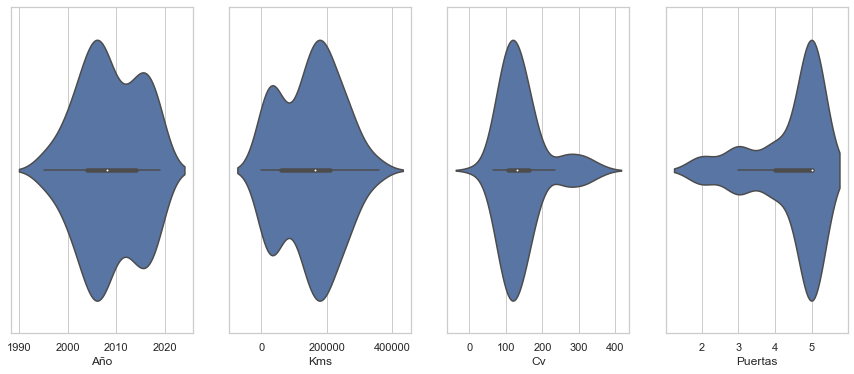

In [41]:
sns.set(style="whitegrid")
f, ax = plt.subplots(1, 4, sharey = True, figsize=(15,6))

contador = 0
for column in numerical_columns:
    sns.violinplot(x=X_train_sample[column], ax=ax[contador])
    contador = contador +1

In [42]:
# veo el número de valores en las columnas categóricas
for column in categorical_columns:
    valores_unicos = X_train_sample[column].nunique()
    print("Columna ", column, "tiene ", valores_unicos, "valores únicos")

Columna  Marca tiene  26 valores únicos
Columna  Modelo tiene  98 valores únicos
Columna  Tiempo tiene  55 valores únicos
Columna  Provincia tiene  42 valores únicos
Columna  Cambio tiene  2 valores únicos
Columna  Combust tiene  4 valores únicos
Columna  Vendedor tiene  2 valores únicos


In [15]:
# Numéricos los cambio por la media
# Cambio, combustible y vendedor onehot_code

In [44]:
# Los numéricos los sustituyo por la media
numerical_transformer = SimpleImputer(strategy='mean')

In [53]:
# Los categóricos un labelencoder
le = LabelEncoder()
for col in categorical_columns:
    print(col)
    X_train_sample.loc[(X_train_sample[col].notnull()),col] = le.fit_transform(X_train_sample[(X_train_sample[col].notnull())][col])

Marca
Modelo
Tiempo
Provincia
Cambio
Combust
Vendedor


In [54]:
X_train_sample.head()

,Marca,Modelo,Tiempo,Provincia,Año,Kms,Cambio,Cv,Combust,Puertas,Vendedor
Id,,,,,,,,,,,
100308,10,87,34,33,2017.0,37426.0,1,115.0,0,5.0,1
42771,2,12,25,26,2019.0,6000.0,0,265.0,0,4.0,1
107868,23,33,50,39,2017.0,43000.0,0,122.0,3,5.0,1
64957,17,44,15,0,2006.0,185000.0,1,110.0,2,5.0,0
138334,3,53,15,2,2008.0,70721.0,1,110.0,0,5.0,1


In [46]:
# Los categóricos los sustituyo por el valor más frecuente y luego le hago un onehot encoder
#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='most_frequent')),
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))
#])

In [55]:
# Defino el preprocesador para ambos tipos de columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns)
        #,('cat', categorical_transformer, categorical_columns)
    ])

In [56]:
# Selecciono el modelo
model = GradientBoostingClassifier()
#model = XGBClassifier(n_estimators=250)

In [57]:
# Hago el pipelie con el preprocesado y el modelo
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [58]:
# Divido el modelo para entrenar y testear
X_train, X_val, y_train, y_val = train_test_split(X_train_sample, y_sample, random_state = 0)

In [59]:
X_train.head()

,Marca,Modelo,Tiempo,Provincia,Año,Kms,Cambio,Cv,Combust,Puertas,Vendedor
Id,,,,,,,,,,,
37950,19,39,4,6,2017.0,16176.0,1,90.0,2,5.0,1
151856,22,78,30,38,2007.0,19000.0,1,165.0,0,5.0,1
109465,13,1,8,29,2012.0,274000.0,1,NaN,2,5.0,0
145685,17,7,47,13,2016.0,29533.0,1,130.0,2,5.0,1
963,24,75,45,25,2011.0,117500.0,0,180.0,2,3.0,1


In [68]:
X_val.head()

,Marca,Modelo,Tiempo,Provincia,Año,Kms,Cambio,Cv,Combust,Puertas,Vendedor
Id,,,,,,,,,,,
85708,3,24,54,23,2019.0,11564.0,1,102.0,0,5.0,1
142649,6,46,11,29,2005.0,169000.0,1,90.0,0,3.0,1
107868,23,33,50,39,2017.0,43000.0,0,122.0,3,5.0,1
129017,24,52,13,26,1995.0,220000.0,1,115.0,2,3.0,0
80883,18,71,22,26,2015.0,20000.0,0,300.0,0,4.0,1


In [69]:
y_train.head()

Id
37950     10995
151856     3950
109465    13500
145685    13177
963       10900
Name: Precio, dtype: int64

In [70]:
y_val.head()

Id
85708     14900
142649     2500
107868    21490
129017     1500
80883     78000
Name: Precio, dtype: int64

In [71]:
print(np.log1p(y_train))

Id
37950     9.305287
151856    8.281724
109465    9.510519
145685    9.486304
963       9.296610
            ...   
115449    9.615872
123930    8.101981
57737     8.412055
98149     9.127067
144986    9.185125
Name: Precio, Length: 75, dtype: float64


In [84]:
# Me da un error al ajustar porque parece que el y_train es un continuo. 
# Voy a convertirlo con un label encoder
#lab_enc = preprocessing.LabelEncoder()
y_train_log = np.log1p(y_train)
#y_train_log_encoded = lab_enc.fit_transform(y_train_log)
#print(utils.multiclass.type_of_target(y_train_log_encode))
print(utils.multiclass.type_of_target(y_train_log))
print(utils.multiclass.type_of_target(y_train))

continuous
multiclass


In [85]:
print(y_train)

Id
37950     10995
151856     3950
109465    13500
145685    13177
963       10900
          ...  
115449    15000
123930     3300
57737      4500
98149      9200
144986     9750
Name: Precio, Length: 75, dtype: int64


In [86]:
# Ya puedo entrenar el modelo
my_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='mean',
                                                                verbose=0),
                                                  ['Año', 'Kms', 'Cv',
                                                   'Puertas'])],
                                   verbose=False)),
                ('model',
        

In [89]:
# Preprocessing of validation data, get predictions
# para calcular la predicción he de hacer la operación inversa al logaritmo, que es el exponene
#preds = np.expm1(my_pipeline.predict(X_val))
preds = my_pipeline.predict(X_val)

In [90]:
print(preds)

[14900  2990 13454  1650  3950  1650  1500  6500  5800  2990  6000 10995
  3299  2000  9750  6990  6300 10995  3299  2990  6300  6500  6800  3299
  1199]


In [91]:
# Muestro el valor de la métrica de la predicción
print(np.sqrt(mean_squared_log_error( y_val, preds )))

0.9621090514371923
